In [141]:
# !pip install pandas_datareader

In [142]:
import math
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas_datareader as pdr
from datetime import datetime, timedelta

In [143]:
#Get the stock
ticker = 'SYY'
stock ="Sysco"
# Time step n days, here we will use n  days historical data to predict next day closing
ts_points = 120
# train_data[0:60,0]  

today = datetime.today()
# start_date ='2016-01-01'
start_date = (today - timedelta(days=5*365) ).strftime('%Y-%m-%d')

# end_date   = today.strftime('%Y-%m-%d')
end_date = (today - timedelta(days=31) ).strftime('%Y-%m-%d')

stock_df = pdr.DataReader(ticker, data_source="yahoo", start=start_date, end=end_date)

In [144]:
# Date is an index but to be sure , let's sort
stock_df = stock_df.sort_index(ascending=True)
stock_df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-10-25,47.910000,47.310001,47.860001,47.439999,3429000.0,41.870029
2016-10-26,47.500000,47.240002,47.380001,47.259998,2356600.0,41.711163
2016-10-27,47.570000,47.150002,47.310001,47.450001,3789900.0,41.878864
2016-10-28,48.279999,47.430000,47.480000,47.990002,3530800.0,42.355457
2016-10-31,48.279999,47.980000,48.110001,48.119999,2843200.0,42.470188
...,...,...,...,...,...,...
2021-09-17,76.879997,75.410004,76.419998,76.089996,3756800.0,75.648109
2021-09-20,76.550003,74.519997,74.949997,76.139999,2202300.0,75.697823
2021-09-21,77.010002,75.800003,76.279999,76.470001,1795600.0,76.025902


In [145]:
# check for nulls
stock_df.isna().sum()

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [146]:
# Get shape
stock_df.shape

(1237, 6)

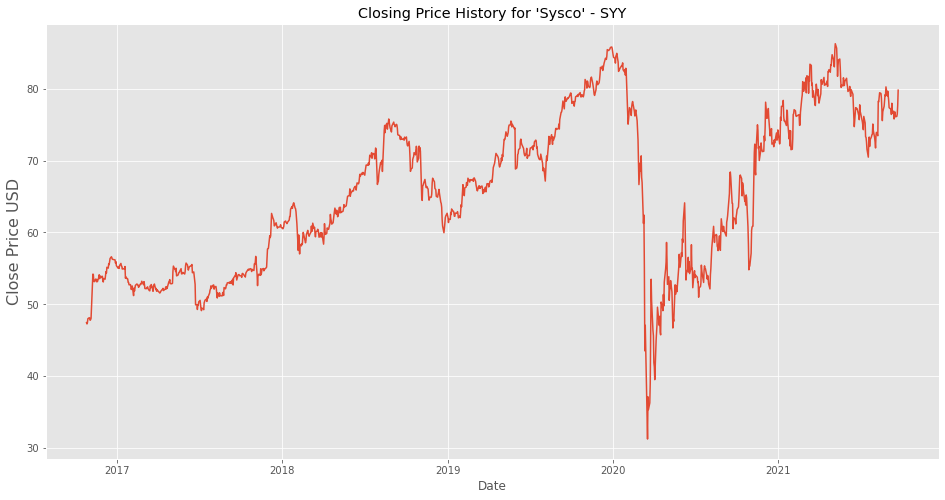

In [147]:
# Visualize closing price history
plt.figure(figsize=(16,8))
plt.title (f"Closing Price History for '{stock}' - {ticker}")
plt.plot(stock_df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD', fontsize=16)
plt.show()

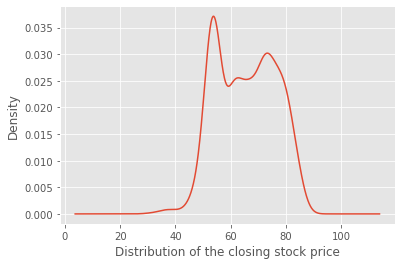

In [148]:
stock_df['Close'].plot.density()
plt.xlabel('Distribution of the closing stock price')
plt.show()

In [149]:
# DF with only close
TSdata_df = stock_df.filter(['Close'])
TSdata_df


,Close
Date,
2016-10-25,47.439999
2016-10-26,47.259998
2016-10-27,47.450001
2016-10-28,47.990002
2016-10-31,48.119999
...,...
2021-09-17,76.089996
2021-09-20,76.139999
2021-09-21,76.470001


In [150]:
TSdata_arr = TSdata_df.values # this creates an array of Close Price
TSdata_arr

array([[47.43999863],
       [47.25999832],
       [47.45000076],
       ...,
       [76.47000122],
       [77.69999695],
       [79.79000092]])

In [151]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np

# ADF Test
result = adfuller(TSdata_arr, autolag='AIC')

print('ADF Statistic: %f' % result[0])

print('p-value: %f' % result[1])

print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -2.273012
p-value: 0.180820
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Failed to Reject Ho - Time Series is Non-Stationary


In [152]:
df2 = TSdata_df['Close'].diff().dropna().to_frame()
df2

,Close
Date,
2016-10-26,-0.180000
2016-10-27,0.190002
2016-10-28,0.540001
2016-10-31,0.129997
2016-11-01,-0.039997
...,...
2021-09-17,-0.670006
2021-09-20,0.050003
2021-09-21,0.330002


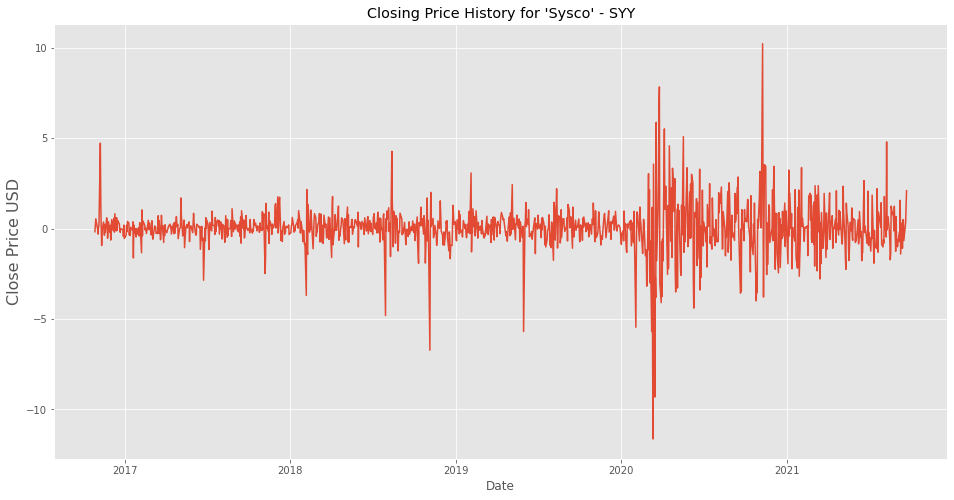

In [153]:
# Visualize closing price history
plt.figure(figsize=(16,8))
plt.title (f"Closing Price History for '{stock}' - {ticker}")
plt.plot(df2['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD', fontsize=16)
plt.show()

In [154]:
# TSdata_arr = df2.filter(['Close']).values
# TSdata_arr

In [155]:
# Scale the Data
scaler = MinMaxScaler(feature_range =(0,1))
scaled_data = scaler.fit_transform(TSdata_arr)
# scaled_data

In [156]:
training_data_len = math.ceil(len(TSdata_arr) * 0.75)
training_data_len

928

In [157]:
# Created scaled training dataset
train_data = scaled_data[0:training_data_len]
train_data.shape

(928, 1)

In [158]:
# Split
X_train = []
y_train = []

for i in range(ts_points, len(train_data)):
    X_train.append(train_data[i-ts_points:i,0])
    y_train.append(train_data[i,0])
    # if i <= ts_points+3:
    #     print(X_train)
    #     print(y_train)
    #     print()


In [159]:
# convert X_train and y_train to numpy arrays for LSTM
X_train, y_train = np.array(X_train), np.array(y_train)

In [160]:
print (X_train.shape)
print (y_train.shape)

(808, 120)
(808,)


In [161]:
# LSTM network expects a 3D input (No_of_Samples, number of time steps, and number of features) no_of_features = 1 (Close)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(808, 120, 1)

In [162]:
training_data_len - ts_points

808

In [163]:
# hidden_nodes = int(2/3 * (X_train.shape[1] * 1))
# print(f"The number of hidden nodes is {hidden_nodes}.")

In [164]:
# LSTM MOdel
model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)))
# model.add(tf.keras.layers.LSTM(50, return_sequences=False))
# model.add(tf.keras.layers.Dropout(0.2))
# model.add(tf.keras.layers.Dense(25))
# model.add(tf.keras.layers.Dense(1))
# model.summary()


In [165]:

# # BEST FOR TESLA#
model.add(tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(tf.keras.layers.LSTM(50, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(25))
model.add(tf.keras.layers.Dense(1))
model.summary()

# #model.fit(X_train, y_train, batch_size=64, epochs=50

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 120, 50)           10400     
_________________________________________________________________
lstm_7 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [166]:
model.compile(optimizer='adam', loss='mean_squared_error')
# model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [167]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint

batch_size=64

os.makedirs("chk_points/", exist_ok=True)
chkpoint_path="chk_points/weights.{epoch}.hdf5"

# Create chk points
chkpt_callback = ModelCheckpoint(filepath=chkpoint_path,
                              verbose=1,
                              save_weights_only=True,
                              save_freq="epoch",
                              period=5)

# chkpoint_path = "chk_points/cp-{epoch:04d}.ckpt"
# chkpt_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=chkpoint_path, 
#     verbose=1, 
#     save_weights_only=True,
#     save_freq=5*batch_size)                    

# model.save_weights(chkpoint_path.format(epoch=0))    


In [168]:
# training_data_len
# scaled_data

In [169]:
# model.fit(X_train, y_train, batch_size=batch_size, epochs=50, validation_split=0.43, callbacks=[chkpt_callback])
model.fit(X_train, y_train, batch_size=64 ,epochs=32)

Epoch 1/32
13/13 [==============================] - 3s 74ms/step - loss: 0.0791
Epoch 2/32
13/13 [==============================] - 1s 71ms/step - loss: 0.0169
Epoch 3/32
13/13 [==============================] - 1s 97ms/step - loss: 0.0110
Epoch 4/32
13/13 [==============================] - 2s 124ms/step - loss: 0.0087
Epoch 5/32
13/13 [==============================] - 1s 115ms/step - loss: 0.0069
Epoch 6/32
13/13 [==============================] - 1s 111ms/step - loss: 0.0066
Epoch 7/32
13/13 [==============================] - 1s 114ms/step - loss: 0.0061
Epoch 8/32
13/13 [==============================] - 2s 121ms/step - loss: 0.0055
Epoch 9/32
13/13 [==============================] - 2s 128ms/step - loss: 0.0050
Epoch 10/32
13/13 [==============================] - 2s 127ms/step - loss: 0.0052
Epoch 11/32
13/13 [==============================] - 2s 142ms/step - loss: 0.0047
Epoch 12/32
13/13 [==============================] - 2s 116ms/step - loss: 0.0049
Epoch 13/32
13/13 [=========

In [170]:
model.save('Saved_Models/Model_'+ticker+'.h5')

In [171]:
# test_data = scaled_data[training_data_len:]

# Bring in the last 'ts_points' (60 values) from training set so when X_test is used to predict , predictions have same shape as Y_test
# The for loop starts with 'ts_points' thatbmeans the resultant array will have 60 less rows
test_data = scaled_data[training_data_len-ts_points:]
# test_data[0:60,0]


In [172]:
X_test = []
y_test = TSdata_arr[training_data_len:]
for i in range(ts_points, len(test_data)):
    X_test.append(test_data[i-ts_points:i,0])


In [173]:
# convert the data to a numpy array to use it in LSTM MODEL
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],  X_test.shape[1], 1))

In [174]:
from sklearn.metrics import mean_squared_error

In [175]:
# Models predicted price for X_train
predictions_tr = model.predict(X_train)
predictions_tr = scaler.inverse_transform(predictions_tr)

y_train_tr =  scaler.inverse_transform(y_train.reshape(-1,1))
rmse_tr = math.sqrt(mean_squared_error(y_train_tr, predictions_tr))
rmse_tr

2.6234641283737545

In [176]:
# Models predicted price for X_test
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

In [177]:
y_test.shape, predictions.shape

((309, 1), (309, 1))

In [178]:
# RMSE to check accuracy

rmse = math.sqrt(mean_squared_error(y_test, predictions))
rmse

3.1049582056176237

In [179]:
# Plot
train = TSdata_df[:training_data_len]
actual = TSdata_df[training_data_len:]
actual['Predictions'] = predictions
actual

<ipython-input-179-bb86776ae978>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual['Predictions'] = predictions


,Close,Predictions
Date,,
2020-07-06,53.759998,53.895885
2020-07-07,53.020000,53.764553
2020-07-08,53.110001,53.594906
2020-07-09,50.980000,53.425392
2020-07-10,52.310001,53.095440
...,...,...
2021-09-17,76.089996,74.401695
2021-09-20,76.139999,74.173569
2021-09-21,76.470001,73.990822


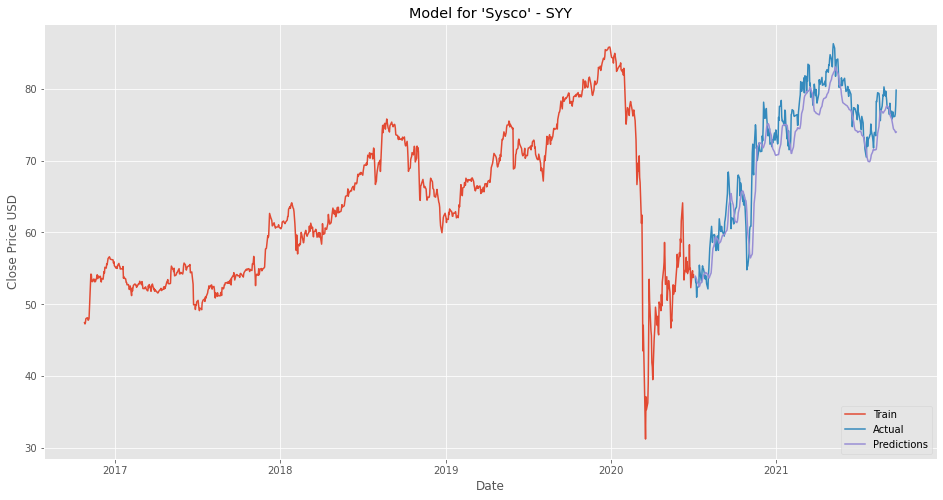

In [180]:
plt.figure(figsize=(16,8))
plt.title(f"Model for '{stock}' - {ticker}")
plt.xlabel("Date")
plt.ylabel("Close Price USD")
plt.plot(train['Close'])
plt.plot(actual[['Close', 'Predictions']])
plt.legend(['Train', 'Actual', 'Predictions'], loc='lower right')
plt.show()

# TEST

In [181]:
# for predictions add 100 extra days to make sure it has more than ts_points to make up for missing days (weekends and holidays)

fetch_days = ts_points + 100    

sd =  today - timedelta(days=fetch_days)
sd = sd.strftime('%Y-%m-%d')

ed = today.strftime('%Y-%m-%d')
ed

next_day = (today + timedelta(days=1) ).strftime('%Y-%m-%d')
# next_day

In [182]:
# get the quote
quote = pdr.DataReader(ticker, data_source="yahoo", start=sd, end=ed)
new_df = quote.filter(['Close'])
last_n_days = ts_points
last_n_days_arr = new_df[-last_n_days:].values 

In [183]:
last_n_days_scaled = scaler.transform(last_n_days_arr)
X_test = []
X_test.append(last_n_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0], X_test.shape[1],1))


In [184]:
##########################loading saved model ###############################
new_model = tf.keras.models.load_model('Saved_Models/Model_'+ticker+'.h5')

# Check its architecture
new_model.summary()
nmpred_price = new_model.predict(X_test)
nmpred_price = scaler.inverse_transform(nmpred_price)
nmpred_price = nmpred_price[0][0]
print(f"Predicted Closing price for '{stock}' on {next_day} is {nmpred_price:.4f}")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 120, 50)           10400     
_________________________________________________________________
lstm_7 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________
Predicted Closing price for 'Sysco' on 2021-10-25 is 78.9880


In [185]:
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
pred_price = pred_price[0][0]
print(f"Predicted Closing price for '{stock}' on {next_day} is {pred_price:.4f}")

Predicted Closing price for 'Sysco' on 2021-10-25 is 78.9880


In [186]:
# verify
d1 = today - timedelta(days=5)
d1 = d1.strftime('%Y-%m-%d')

quote2 = pdr.DataReader(ticker, data_source="yahoo", start=d1)
quote2

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-10-19,81.730003,79.489998,81.680000,81.339996,2066400,81.339996
2021-10-20,81.580002,79.680000,81.339996,79.820000,2737600,79.820000
2021-10-21,80.760002,79.330002,79.900002,79.629997,1567100,79.629997
2021-10-22,79.989998,78.639999,79.540001,78.680000,1418400,78.680000
